This is my first (last?) blog post. I started writing this post as an assignement for Udacity's Data Scientist nanodegree. 

In the end, this exercise was quite interesting and I learned a few tricks on the way. I am aspiring data scientist and I don't have the exultant self-confidence that you can find in even the worst blog posts available online. To make things more interesting, I decided to write as much about the business questions selected for this data as I discuss the very process of inquiring data and all the doubts and questions that arise from it.

In [1129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re as re

%matplotlib inline

In [1185]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.feature_extraction import text 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [1442]:
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 4000)
pd.options.display.max_colwidth = 500

Each city has three datasets: calendar, listings and reviews. Let's load all of them.

In [1426]:
boston_calendar = pd.read_csv('data/boston/calendar.csv')
boston_listings = pd.read_csv('data/boston/listings.csv')
boston_reviews = pd.read_csv('data/boston/reviews.csv')

seattle_calendar = pd.read_csv('data/seattle/calendar.csv')
seattle_listings = pd.read_csv('data/seattle/listings.csv')
seattle_reviews = pd.read_csv('data/seattle/reviews.csv')

The calendar dataframe looks very ordinary. It tells us the id of the property and if it is available or not on a certain day. It also contains the rent price.

In [923]:
boston_calendar.head()

,listing_id,date,available,price,year,month,day
0,12147973,2017-09-05,f,NaN,2017,09,05
1,12147973,2017-09-04,f,NaN,2017,09,04
2,12147973,2017-09-03,f,NaN,2017,09,03
3,12147973,2017-09-02,f,NaN,2017,09,02
4,12147973,2017-09-01,f,NaN,2017,09,01


The reviews dataset is also quite simple. It basically identifies the property and the reviewer with its comments. Unfortunately I won't touch this dataframe because it is too complicated to get something out of the reviews. Reviews are written in different languages and most of them are speaking well about the place.

When I looked at this dataset I immediately thought that I should do sentiment analysis to assess how well each property fared. However, real life is always more complicated than Newsroom. 

In [699]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


The listings dataframe is much more complex than the previous two.. Although shorter, it contains many more columns with much more information. Let's take a look at one of the entries.

In [700]:
boston_listings.iloc[1,:]

id                                                                            3075044
listing_url                                      https://www.airbnb.com/rooms/3075044
scrape_id                                                              20160906204935
last_scraped                                                               2016-09-07
name                                                Charming room in pet friendly apt
summary                             Charming and quiet room in a second floor 1910...
space                               Small but cozy and quite room with a full size...
description                         Charming and quiet room in a second floor 1910...
experiences_offered                                                              none
neighborhood_overview               The room is in Roslindale, a diverse and prima...
notes                               If you don't have a US cell phone, you can tex...
transit                             Plenty of safe str

In [1449]:
boston_listings.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              143
space                               1057
description                            0
experiences_offered                    0
neighborhood_overview               1415
notes                               1975
transit                             1290
access                              1489
interaction                         1554
house_rules                         1192
thumbnail_url                        599
medium_url                           599
picture_url                            0
xl_picture_url                       599
host_id                                0
host_url                               0
host_name                              0
host_since                             0
host_location                         11
host_about      

There is a lot of information here but some of it is not really useful.

## Business Questions

These are the steps of the CRISP-DM process:


With such rich dataset is easy to come with a few interesting business questions. Here are the ones that I am curious about:

1. Easy one: How occupation change with time?
2. Can we determine what are the main predictors for property price?
3. What are the characteristics of the most sought after properties?
4. What are the most popular neighbourhoods? Can we understand why they are popular?
5. Can we relate reviews with property popularity?

Bonus: Do Airbnb affect renting for local population?

## 1. How occupation change with time? 

The first question that came to my mind was to check occupation as a function of time. This is a pretty easy one but it can give us some insight about the dataset. Let's take a look at the calendar. It has dates condensed in a single string. What we need to do is to break them up in separate year, month, and day columns. 

In [701]:
# convert dates to year - month - day
boston_calendar[['year','month','day']] = boston_calendar['date'].str.split(pat='-', expand=True)
seattle_calendar[['year','month','day']] = seattle_calendar['date'].str.split(pat='-', expand=True)

In [1028]:
palette = sns.color_palette("BrBG",7)
boston1 = palette[0]
boston2 = palette[1]
seattle1 = palette[6]
seattle2 = palette[5]

In [29]:
# get base colors for boston and seattle
base_color = sns.color_palette()[1]
boston1 = sns.color_palette('Paired')[0]
boston2 = sns.color_palette('Paired')[1]
seattle1 = sns.color_palette('Paired')[6]
seattle2 = sns.color_palette('Paired')[7]

### What is the average occupation per month?

According to the calendar dataframe, everytime an unit is occupied, the price is shown as NaN. So we can come with a quite straightforward way to measure occupation. You just need to count the number of NaNs per month.

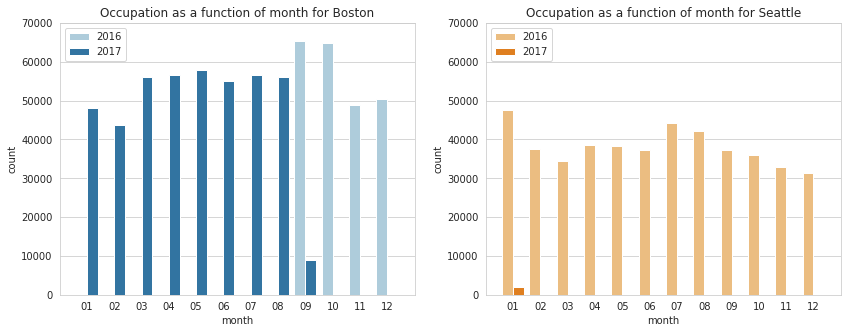

In [1012]:
boston_ = boston_calendar[boston_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
boston_.rename(columns={0:'count'}, inplace=True)
seattle_ = seattle_calendar[seattle_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
seattle_.rename(columns={0:'count'}, inplace=True)

sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x='month', y='count', hue='year', data=boston_, ax=ax1, palette=[boston1,boston2]);
ax1.legend(loc='upper left');
ax1.set_title('Occupation as a function of month for Boston')
ax1.set_xlim((-1,12));
ax1.set_ylim((0,70000));
sns.barplot(x='month', y='count', hue='year', data=seattle_, ax=ax2, palette=[seattle1,seattle2]);
ax2.legend(loc='upper left');
ax2.set_title('Occupation as a function of month for Seattle')
ax2.set_xlim((-1,12));
ax2.set_ylim((0,70000));

For Boston, the occupation is quite steady during spring and summer and lower during winter. However, the data doesn't comprise a whole year so we cannot be quite sure about this trend. For Seattle, January is very popular, probably due to winter birds escaping from Canada (like myself). We also see some high demand during the peak of summer. However, as happened with Boston, the data does not show mulitple years so we cannot draw any definite conclusions.

That was too easy. Let's try something fancier. Another way of looking into occupation is to check how many days each unit has been occupied. That's actually not that hard: we simply need to count for how long each unit has been not available throughout the whole dataframe.

In [938]:
boston_calendar['occupied'] = boston_calendar['available'].apply(lambda x: 1 if x=='f' else 0)
seattle_calendar['occupied'] = seattle_calendar['available'].apply(lambda x: 1 if x=='f' else 0)

In [995]:
boston_rent = boston_calendar.groupby('listing_id').agg({'occupied':'sum'}).reset_index()
seattle_rent = seattle_calendar.groupby('listing_id').agg({'occupied':'sum'}).reset_index()

In [1005]:
boston_rent.head()

,listing_id,occupied
0,3353,116
1,5506,21
2,6695,41
3,6976,46
4,8792,117


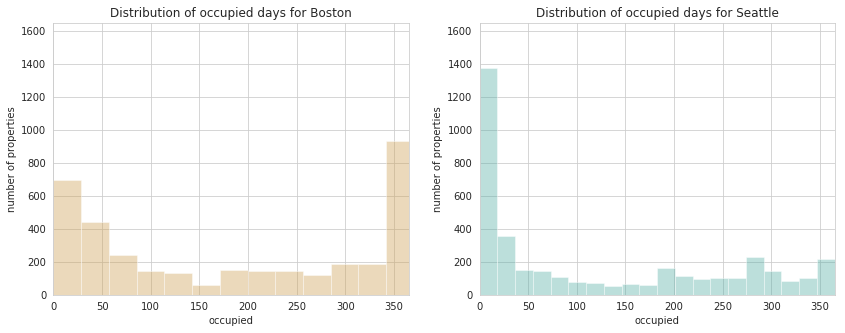

In [1037]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.distplot(boston_rent['occupied'], ax=ax1, kde=False, color=boston2, bins=20);
#ax1.legend(loc='upper left');
ax1.set_title('Distribution of occupied days for Boston')
ax1.set_xlim((0,365));
ax1.set_ylim((0,1650));
ax1.set_ylabel('number of properties')
sns.distplot(seattle_rent['occupied'], ax=ax2, kde=False, color=seattle2, bins=20);
ax2.set_title('Distribution of occupied days for Seattle')
ax2.set_ylim((0,1650));
ax2.set_xlim((0,365))
ax2.set_ylabel('number of properties');

The property occupation for Boston has a peak about 350 days. Are these properties rented out to students? 

Let's create a dataframe containing just the units that were rented out for more than 350 days.

In [998]:
boston_350 = boston_rent[boston_rent['occupied']>350].copy()

In [999]:
boston_350.shape

(856, 2)

In [1000]:
boston_350 = boston_350.merge(boston_listings, how='inner', left_on='listing_id', right_on = 'id')

In [1001]:
boston_350.shape

(856, 97)

In [1002]:
boston_350.groupby('neighbourhood_cleansed').size().sort_values(ascending=False).reset_index()[:10]

,neighbourhood_cleansed,0
0,Allston,108
1,South End,80
2,Jamaica Plain,79
3,Fenway,69
4,Back Bay,66
5,Brighton,58
6,Beacon Hill,55
7,North End,49
8,Mission Hill,47
9,Downtown,45


That's interesting. Allston is quite close to Harvard and more affordable than Cambridge. That's not conclusive, but provides some evidence for my guess that these year-round rented units are occupied by students.

On the other hand, the property occupation for Seattle is what I would imagine as typical: most of the properties were rented for just about a month over an year. Contrasting with Boston, just a few properties were in high demand throughout the year.

Are these long-term rents a measure of success. Of course, the unit is occupied but that might be by just one tenant throughout months. It would be interesting to measure how many times the listing was converted into a new tenant. For that we create a new column containing the average times the unit was rented. We calculate it by simply dividing the days the unit was occupied by the average time it was available (maximum_nights + minimum_nights) / 2.

In [1003]:
def n_rents(df_rent, df_listings):
    df_rent = df_rent.merge(df_listings, how='inner', left_on='listing_id', right_on='id', suffixes=(False,False))
    df_rent['avg_nights'] = (df_listings['maximum_nights'] + df_listings['minimum_nights']) / 2.0
    df_rent['n_rent'] = df_rent['occupied'] / df_rent['avg_nights']
    
    return df_rent

In [1033]:
boston_merge = n_rents(boston_rent, boston_listings)
seattle_merge = n_rents(seattle_rent, seattle_listings)

In [1034]:
boston_merge.shape, boston_listings.shape, boston_merge.isnull().values.any()

((3585, 99), (3585, 95), True)

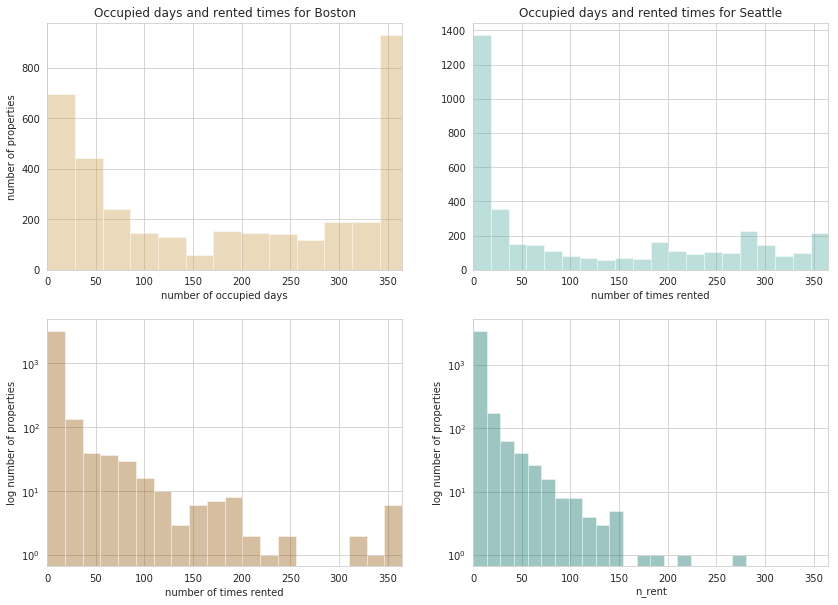

In [1039]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.distplot(boston_rent['occupied'], ax=axes[0][0], kde=False, color=boston2, bins=20);
sns.distplot(boston_merge['n_rent'], ax=axes[1][0], kde=False, color=boston1, bins=20)
#ax1.legend(loc='upper left');
axes[0][0].set_title('Occupied days and rented times for Boston')
axes[0][0].set_xlim((0,365));
axes[0][0].set_xlabel('number of occupied days')
axes[0][0].set_ylabel('number of properties')
axes[1][0].set_xlim((0,365));
axes[1][0].set_yscale('log');
axes[1][0].set_xlabel('number of times rented')
axes[1][0].set_ylabel('log number of properties')
#ax1.set_ylim((0,1650));
sns.distplot(seattle_rent['occupied'], ax=axes[0][1], kde=False, color=seattle2, bins=20);
sns.distplot(seattle_merge['n_rent'], ax=axes[1][1], kde=False, color=seattle1, bins=20);
axes[0][1].set_title('Occupied days and rented times for Seattle')
axes[0][1].set_xlim((0,365));
axes[0][1].set_xlabel('number of occupied days')
axes[1][1].set_ylabel('number of properties')
axes[1][1].set_xlim((0,365));
axes[1][1].set_yscale('log');
axes[0][1].set_xlabel('number of times rented')
axes[1][1].set_ylabel('log number of properties');


That's very good. Measuring with n_rent instead of occupation eliminated most of the long-term renting effect. It gives us a more reliable parameter for how many times a unit catches the attention of a new user. That's important if we want to measure how effective our listing is and how well our property stacks with others in the same category.

## 2. Can we determine what are the main predictors for property price?

This one might be a common question for property owners: What are most important property features that I need to take care of if I want to be successful attracting customers?

I tried to solve this problem by training a supervised learning classifier using four categories of price range as a target. The answer to our question will be in the list of most important features that some types of classifiers return after fitting the model. 

Starting with the merged dataframes that we created above, we narrow down the columns that I guessed might have the highest impact in solving this question.

In [1217]:
# I arbitrarily chose these columns 
list_columns = ['id',
                'host_since',
                'host_response_rate',
                'host_acceptance_rate',
                'host_is_superhost',
                'host_listings_count',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms',
                'bedrooms',
                'beds',
                'bed_type',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights',
                'n_rent',
                'occupied',
                'number_of_reviews',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'instant_bookable',
                'cancellation_policy',
                'require_guest_profile_picture',
                'require_guest_phone_verification' ]

Some of the columns are obvious but, for example, the column require_guest_profile_picture is not a clear choice. I chose it because if I am a privacy-oriented guest, I would rather not have my picture available on Airbnb (maybe not, that's just a guess. Maybe I would not even use Airbnb).

Let's now define a pipeline to clean the data before processing by a supervised learning method.

In [1459]:
def price_pipeline(df):
    #df.dropna(axis=1, inplace=True) # very few null values for the selected columns
    df.dropna(subset=['host_since'], inplace=True)
    df['host_since'] = df['host_since'].str.split(pat='-', expand=True)[0]
    base_year = pd.to_numeric(df['host_since'].unique().min())
    df['host_since'] = df['host_since'].apply(lambda x: pd.to_numeric(x) - base_year)
    
    df['host_response_rate'].fillna('0%', inplace=True)
    df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    df['host_acceptance_rate'].fillna('0%', inplace=True)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    
    df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)    
    df['amenities'] = df['amenities'].str.strip('{,}').str.split(pat=',', expand=True).isnull().sum(axis=1)    
    
    df.dropna(subset=['price'], inplace=True)
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_phone_verification'] = df['require_guest_phone_verification'].apply(lambda x: 0 if x=='f' else 1)

    # imputing missing values
    
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df['bathrooms'] = imp_median.fit_transform(df[['bathrooms']])
    df['bedrooms'] = imp_median.fit_transform(df[['bedrooms']])
    df['beds'] = imp_median.fit_transform(df[['beds']])
    
    imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df['property_type'] = imp_mf.fit_transform(df[['property_type']])
    
    # review columns section
    review_re = re.compile('^review')
    list_review = list(filter(review_re.match, df.columns.values.tolist()))
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[list_review] = imp_mean.fit_transform(df[list_review])
    
    # dummies section
    list_dummies = df.select_dtypes(include='object').columns.values.tolist()
    df_dummies = pd.get_dummies(df[list_dummies], drop_first=True)
    df2_neigh = df['neighbourhood_cleansed']
    df2 = pd.merge(df, df_dummies, left_index=True, right_index=True).drop(list_dummies, axis=1)
    
    # separate id column
    df2_id = df2['id']
    df2.drop('id', axis=1, inplace=True)
    
    # scaler section
    list_scale = df.select_dtypes(include=['float64','int64']).columns.values.tolist()
    list_scale.remove('id')
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    df2[list_scale] = scaler.fit_transform(df2[list_scale])
    
    
    return df2_id, df2_neigh, df2

This pipeline returns two dataframes: one with just the ids in case we want to use them later and the other with all selected columns properly cleaned from null values, with categorical variables converted to dummies and with numeric variables scaled. 

In [1460]:
boston_id, boston_neigh, boston_df = price_pipeline(boston_merge[list_columns].copy())
seattle_id, seattle_neigh, seattle_df = price_pipeline(seattle_merge[list_columns].copy())

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


The next step is to train a regressor with these dataframes. However, after much work, I could not get any regressor to give me any decent result. 

In [1220]:
boston_df.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,n_rent,occupied,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,0.000,0.9,0.78,0.0,0.008011,0.000000,0.166667,0.2,0.0625,0.666667,0.007519,0.020067,3.640000e-06,0.000564,0.203509,0.084158,0.8750,0.875,0.750,0.875,0.833333,0.875,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0.125,1.0,0.90,0.0,0.009346,0.066667,0.166667,0.2,0.0625,0.766667,0.033835,0.006689,7.290000e-06,0.006769,0.036842,0.089109,0.8875,0.875,1.000,1.000,1.000000,0.875,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,0.125,1.0,0.90,0.0,0.009346,0.200000,0.166667,0.2,0.1250,0.433333,0.046366,0.006689,7.290000e-06,0.004680,0.071930,0.116337,0.9375,0.875,1.000,1.000,1.000000,0.750,0.875,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.125,1.0,0.88,1.0,0.001335,0.066667,0.166667,0.2,0.0625,0.433333,0.013784,0.006689,4.400000e-07,0.000224,0.080702,0.101485,0.9750,1.000,0.875,1.000,1.000000,0.875,1.000,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,0.125,1.0,0.93,0.0,0.016021,0.133333,0.166667,0.2,0.0625,0.733333,0.036090,0.096990,3.640000e-06,0.019427,0.205263,0.044554,0.8875,1.000,0.875,1.000,0.833333,1.000,1.000,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [1221]:
bdf = boston_df.copy()
target='price'
y = bdf[target]
X = bdf.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_reg = AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=1.0)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

0.061104666346825764

My guess is that the datasets are too sparse and too small for any regressor to perform well. Moreover, if we inspect pairs of variables using scatter plots, we can see that there is no clear trend in the data.

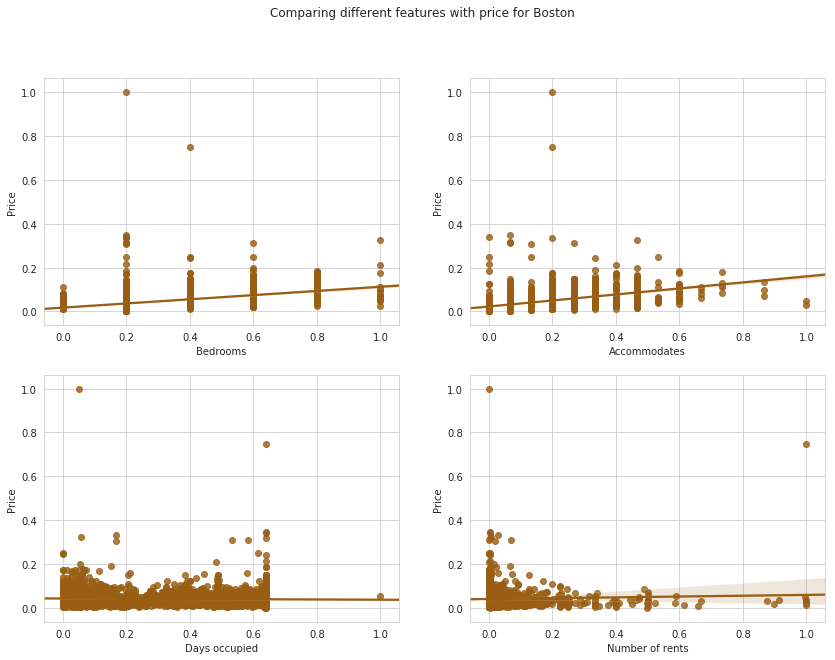

In [1227]:
select_df = boston_df[['bedrooms','occupied','accommodates','price','n_rent']].copy()
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.regplot(x='bedrooms', y='price', data=select_df, ax=axes[0][0], color=boston1);
sns.regplot(x='occupied', y='price', data=select_df, ax=axes[1][0], color=boston1)
sns.regplot(x='accommodates', y='price', data=select_df, ax=axes[0][1], color=boston1);
sns.regplot(x='n_rent', y='price', data=select_df, ax=axes[1][1], color=boston1)
#ax1.legend(loc='upper left');
plt.suptitle('Comparing different features with price for Boston')
axes[0][0].set_xlabel('Bedrooms')
axes[0][0].set_ylabel('Price')
axes[1][0].set_xlabel('Days occupied')
axes[1][0].set_ylabel('Price')
axes[0][1].set_xlabel('Accommodates')
axes[0][1].set_ylabel('Price')
axes[1][1].set_xlabel('Number of rents')
axes[1][1].set_ylabel('Price');

One solution for this issue is to turn a regression problem into a classification problem. We define four price categories based on the quartiles of the price distribution and make predictions about these classes.

Using Ada Boost as the classifier, we run 5-fold cross-validation cycles, getting an acceptable result.

In [1522]:
bdf = boston_df.copy()
target='price'
qt = bdf[target].quantile([.25,.50,.75]).values.tolist()
bdf['score'] = bdf[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bdf.drop(target, axis=1, inplace=True)
y = bdf['score']
X = bdf.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
skf = StratifiedKFold(n_splits=5, random_state=34)
y_true = []
y_preds = []
for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_test_kf, y_test_kf = X_train.iloc[test_idx, :], y_train.iloc[test_idx]
    ab_clf.fit(X_train_kf, y_train_kf)
    y_preds.extend(ab_clf.predict(X_test_kf))
    y_true.extend(y_test_kf)
    
print(accuracy_score(y_true, y_preds))

0.5472719700124948


Next, we can use some tricks to improve this result. We first run GridSearchCV to optimize the hyperparameters.

In [1523]:
parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 150, 200, 250, 300, 350, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
print(grid_clf.best_score_)
best_clf_b = grid_clf.best_estimator_

0.5514369012911287


That didn't improve a lot.

Next, we try to optimize the dataframe itself by selecting the columns to be considered. One way to do this is by adding all the elements of each column and only picking the column if the sum is less than some cutoff.

In [1524]:
cutoffs=[2500, 2000, 1500, 1000, 500, 100, 50, 30, 25, 0]
for c in cutoffs:
    X_red = X_train.iloc[:, np.where((X.sum()>c)==True)[0]]
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_c = []
    y_preds_c = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        best_clf_b.fit(X_train_kf, y_train_kf)
        y_preds_c.extend(best_clf_b.predict(X_test_kf))
        y_true_c.extend(y_test_kf)
    print('cuttoff: {}, accuracy: {}'.format(c, accuracy_score(y_true_c, y_preds_c)))

ValueError: Number of features of the model must match the input. Model n_features is 134 and input n_features is 11 

Using all columns (the smaller the cutoff the more columns are used) led to the best result. We don't drop any column.

Another interesting way of optimizing the dataframe is by using Recursive Feature Elimination. Despite the ugly name, this technique is not that complicated. We define the number of features we want and RFE will eliminate the least important columns until we get that number.

In [1234]:
rfe_n = []
rfe_acc = []
for i in range(2,X.shape[1]):
    rfe_ab = RFE(best_clf, n_features_to_select=i)
    rfe_ab = rfe_ab.fit(X, y)
    X_red = X_train.iloc[:,rfe_ab.support_]
    rfe_n.append(i)
    
    skf = StratifiedKFold(n_splits=5, random_state=34)
    y_true_rfe = []
    y_preds_rfe = []
    for train_idx, test_idx in skf.split(X_red, y_train):
        X_train_kf, y_train_kf = X_red.iloc[train_idx, :], y_train.iloc[train_idx]
        X_test_kf, y_test_kf = X_red.iloc[test_idx, :], y_train.iloc[test_idx]
        best_clf_b.fit(X_train_kf, y_train_kf)
        y_preds_rfe.extend(best_clf_b.predict(X_test_kf))
        y_true_rfe.extend(y_test_kf)
    rfe_acc.append(accuracy_score(y_true_rfe, y_preds_rfe))

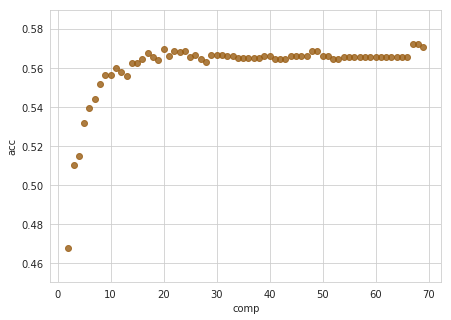

In [1241]:
df_rfe = pd.DataFrame({'comp':rfe_n, 'acc':rfe_acc})
fig, ax1 = plt.subplots(1, figsize=(7,5))
sns.regplot(x='comp', y='acc', ax=ax1, data=df_rfe, color=boston1, fit_reg=False);
plt.title('Results for Recursive Feature Elimination')

In [1516]:
accuracy_score(y_test, best_clf.predict(X_test))

0.5827702702702703

In [1525]:
best_clf_b.fit(X, y)

features_b = pd.DataFrame(best_clf_b.feature_importances_,
                                   index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

features_b.reset_index(inplace=True)
features_b.head()

,index,importance
0,room_type_Private room,0.080000
1,accommodates,0.062857
2,bedrooms,0.060000
3,neighbourhood_cleansed_Downtown,0.051429
4,room_type_Shared room,0.048571


Now we do the same for Seattle (except for the optimization of the dataset):

In [1528]:
features_b['cumsum'] = np.cumsum(features_b['importance'])

In [1526]:
sdf = seattle_df.copy()
target='price'
qt = sdf[target].quantile([.25,.50,.75]).values.tolist()
sdf['score'] = sdf[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
sdf.drop(target, axis=1, inplace=True)
y = sdf['score']
X = sdf.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
skf = StratifiedKFold(n_splits=5, random_state=34)
y_true = []
y_preds = []
for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_test_kf, y_test_kf = X_train.iloc[test_idx, :], y_train.iloc[test_idx]
    ab_clf.fit(X_train_kf, y_train_kf)
    y_preds.extend(ab_clf.predict(X_test_kf))
    y_true.extend(y_test_kf)
    
print(f'accuracy score: {accuracy_score(y_true, y_preds)}')

parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 150, 200, 250, 300, 350, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
print(f'Grid best score: {grid_clf.best_score_}')
best_clf_s = grid_clf.best_estimator_
accuracy_score(y_test, best_clf_s.predict(X_test))
best_clf_s.fit(X, y)

importances = best_clf_s.feature_importances_
features_s = pd.DataFrame(importances, 
                                   index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

features_s.reset_index(inplace=True)
features_s.head()

accuracy score: 0.5477308294209703
Grid best score: 0.5715962441314554


,index,importance
0,accommodates,0.082
1,bedrooms,0.074
2,room_type_Private room,0.072
3,occupied,0.062
4,neighbourhood_cleansed_Belltown,0.046


In [1544]:
features_s['cumsum'] = np.cumsum(features_s['importance'])

Text(0.5, 1.0, 'Most Important Features for Seattle')

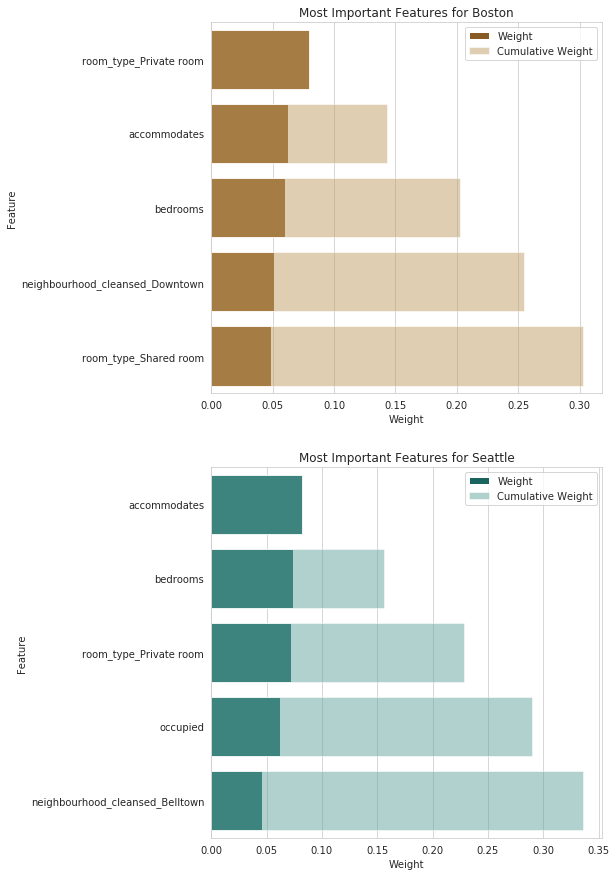

In [1547]:
fig, axis = plt.subplots(2,1, figsize=(7,15))
#plt.suptitle('Normalized Weights for First Five Most Predictive Features')
sns.barplot(x='importance', y='index', data=features_b.iloc[:5], ax=axis[0], color=boston1, ci=None, label='Weight')
sns.barplot(x='cumsum', y='index', data=features_b.iloc[:5], ax=axis[0], color=boston2, alpha=0.5, ci=None, label='Cumulative Weight')
#plt.xticks(rotation=90)
axis[0].legend()
axis[0].set_ylabel('Feature')
axis[0].set_xlabel('Weight')
axis[0].set_title('Most Important Features for Boston')
sns.barplot(x='importance', y='index', data=features_s.iloc[:5], ax=axis[1], color=seattle1, ci=None, label='Weight')
sns.barplot(x='cumsum', y='index', data=features_s.iloc[:5], ax=axis[1], color=seattle2, alpha=0.5, ci=None, label='Cumulative Weight')
axis[1].legend()
axis[1].set_ylabel('Feature')
axis[1].set_xlabel('Weight')
axis[1].set_title('Most Important Features for Seattle')

In question 2 we asked if we can determine what are the main predictors for property price. The answer is yes, given that we create different classes for the price value. 

We found that for Boston the most important features determining price are:

1. Room is a private room
2. Number of people that can be accommodated in the property
3. Number of bedrooms
4. If the property is in Downtown
5. If the room is a shared room.

For Seattle the result is mostly the same. The important features determining price are:

1. Room is a private room
2. For how many days it is occupied
3. Number of bedrooms
4. Number of reviews
5. Host response rate

## 3. What are the characteristics of the most sought after properties?

We would like to know what are the characteristics of a property that is in high demand. Following the same approach we used for the previous question, we define a four-star classification based this time in the feature n_rent which is  the number of times a unit was rented during the entire time period of the dataset.

The idea here is to use PCA to reduce dimensionality of the dataset and to aggregate original features into new variables, which are more meaningful for this problem. Then, using k-means clustering, we find how these features are aggregated in different classes. Last, we find to which classes most of the 4-star properties belong. Fear not! This is not as complicated as it sounds.

In [1249]:
bdf_pca = boston_df.copy()
sdf_pca = seattle_df.copy()

target='n_rent'
qt = bdf_pca[target].quantile([.25,.50,.75]).values.tolist()
boston_target = pd.Series(bdf_pca[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )

qt = sdf_pca[target].quantile([.25,.50,.75]).values.tolist()
seattle_target = pd.Series(sdf_pca[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )

In [1339]:
def pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim_{}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

Our PCA model will have 20 dimensions, which corresponds to about 80% of explained variance. Notice that the original dataframe had 71 dimensions

In [1340]:
n_dim = 20
pca_model_b, var_pca_b, X_pca_b = pca(bdf_pca, n_dim)
pca_model_s, var_pca_s, X_pca_s = pca(sdf_pca, n_dim)

In [1341]:
def scree_plot_pca(pca, ax=None, **kwargs):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    color = kwargs.pop('color')
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    ax = ax or plt.gca()
    ax.bar(idx, vals*10, color=color)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    for i in range(num_comp):

        ax.annotate(r"%s" % ((str(vals[i]*100)[:4])), 
                    (idx[i], vals[i]*10), 
                    va="bottom", 
                    ha="center", 
                    fontsize=8)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    #plt.title("Explained Variance per Principal Component")
    
    return ax

Text(0.5, 1.0, 'PCA components for Seattle')

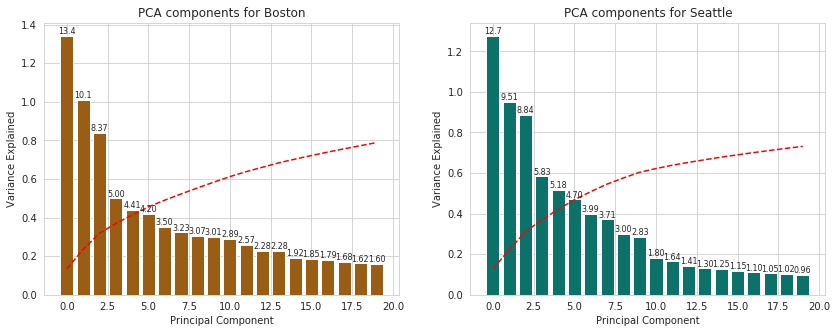

In [1342]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
scree_plot_pca(pca_model_b, ax1, color=boston1)
ax1.set_title('PCA components for Boston')
scree_plot_pca(pca_model_s, ax2, color=seattle1)
ax2.set_title('PCA components for Seattle')

In [1343]:
var_pca.head()

,Explained_Variance,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,n_years,review_agg,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,n_rent,score
Dim 0,0.9810,-0.0005,-0.0004,-0.0002,-0.0031,-0.0032,-0.0017,-0.0026,-0.0022,0.0007,-0.0040,-0.0013,-0.0002,-0.0017,0.0002,0.0000,-0.0005,0.0039,0.0024,0.0007,0.0002,0.0001,0.0001,0.0003,-0.0005,0.0006,-0.0018,-0.0002,-0.0000,-0.0000,0.0000,0.0002,0.0002,0.0001,-0.0002,0.0000,0.0001,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0002,0.0001,0.0001,-0.0001,-0.0001,-0.0001,-0.0001,0.0000,-0.0000,0.0002,-0.0000,-0.0000,-0.0000,-0.0005,0.0003,0.0000,-0.0000,0.0000,1.0000,-0.0020
Dim 1,0.0041,0.0217,-0.0037,0.0057,0.1692,0.4124,0.2258,0.3670,0.3739,-0.1685,0.3033,0.0089,-0.0010,0.0147,-0.0050,0.0026,0.0364,-0.4219,0.0146,-0.1350,-0.0093,-0.0011,-0.0050,-0.0023,0.0131,-0.0093,0.0565,0.0199,0.0111,0.0015,0.0007,-0.0103,0.0023,0.0057,-0.0136,0.0114,-0.0056,0.0016,-0.0030,0.0019,0.0002,-0.0005,-0.0025,-0.0056,0.0038,-0.0017,-0.0009,0.0048,0.0061,0.0037,0.0054,-0.0015,-0.0026,0.0032,-0.0001,0.0030,-0.0003,-0.0000,0.0000,-0.0103,0.0006,0.0006,-0.0033,-0.0003,0.0080,0.3897
Dim 2,0.0032,0.0123,0.0043,0.0102,-0.0318,-0.2007,-0.1197,-0.1900,-0.2009,0.1409,-0.0573,0.0173,0.0244,0.2130,-0.0110,0.0149,0.0474,-0.8704,-0.0880,0.0542,0.0010,-0.0001,0.0017,0.0016,-0.0051,0.0138,-0.0208,0.0275,0.0033,-0.0015,0.0018,-0.0052,0.0001,-0.0050,0.0122,-0.0012,0.0025,-0.0112,-0.0014,0.0105,0.0001,-0.0002,-0.0005,0.0014,0.0008,0.0017,0.0074,-0.0076,-0.0074,0.0048,-0.0023,-0.0009,0.0040,0.0007,-0.0002,-0.0110,0.0000,-0.0003,-0.0003,0.0068,0.0006,0.0013,-0.0036,0.0001,0.0014,-0.1584
Dim 3,0.0015,-0.0145,-0.0620,-0.0621,0.5247,-0.1826,-0.1352,-0.2367,-0.2846,0.1060,0.3290,0.2744,-0.0750,-0.4547,-0.0599,-0.0101,0.0397,-0.0082,-0.0352,-0.1087,-0.0016,0.0001,-0.0036,-0.0012,0.0046,-0.0613,0.0510,0.0421,0.0417,0.0016,0.0100,-0.0125,-0.0047,0.0181,-0.0347,0.0167,-0.0199,0.0453,-0.0037,-0.0471,-0.0001,-0.0007,-0.0032,0.0034,-0.0088,-0.0088,-0.0119,-0.0170,0.0102,0.0252,0.0145,-0.0061,-0.0023,-0.0010,-0.0001,-0.0044,-0.0002,-0.0006,0.0001,-0.0959,0.0006,-0.0006,-0.0042,-0.0000,0.0012,0.2740
Dim 4,0.0013,-0.0220,-0.0211,-0.0593,0.0708,0.0578,0.3516,0.1972,0.1435,0.4467,-0.0021,0.2415,-0.0898,-0.1571,-0.0030,-0.0086,-0.0014,0.0245,-0.6169,0.1053,0.0054,0.0007,0.0029,-0.0011,-0.0063,-0.0443,-0.0036,0.0050,-0.0225,-0.0003,-0.0191,0.0143,-0.0031,-0.0017,0.0407,-0.0190,0.0101,-0.0028,0.0039,-0.0013,-0.0012,-0.0004,0.0047,0.0139,-0.0130,0.0008,0.

Next we need to check which columns are the most important for each PCA component. 

In [1344]:
def pca_analysis(var_pca, component):
    '''
    Generate a dataframe with the attributes listed by weight for
    a given component.
    
    INPUT: var_pca - dataframe with the PCA output
           component - number of the component
           
    OUTPUT: dataframe with attributes and weights
    '''
    
    df = pd.DataFrame(var_pca.iloc[component,:].sort_values(axis=0, ascending=False))
    df['attribute_{}'.format(component)] = df.index
    df.set_index(np.arange(var_pca.shape[1]), inplace=True)

    return df

In [1379]:
list_df_b = []
list_df_s = []
for i in range(1,n_dim):
    list_df_b.append(pca_analysis(var_pca_b, i))
    list_df_s.append(pca_analysis(var_pca_s, i))
var_comp_b = pd.concat([x for x in list_df_b],axis=1).reset_index()
var_comp_s = pd.concat([x for x in list_df_s],axis=1).reset_index()

In [1380]:
var_comp_b.head()

,index,Dim_1,attribute_1,Dim_2,attribute_2,Dim_3,attribute_3,Dim_4,attribute_4,Dim_5,attribute_5,Dim_6,attribute_6,Dim_7,attribute_7,Dim_8,attribute_8,Dim_9,attribute_9,Dim_10,attribute_10,Dim_11,attribute_11,Dim_12,attribute_12,Dim_13,attribute_13,Dim_14,attribute_14,Dim_15,attribute_15,Dim_16,attribute_16,Dim_17,attribute_17,Dim_18,attribute_18,Dim_19,attribute_19
0,0,0.5942,room_type_Private room,0.4239,room_type_Private room,0.8761,instant_bookable,0.5708,property_type_House,0.5189,property_type_House,0.4983,host_is_superhost,0.6585,neighbourhood_cleansed_South End,0.5122,neighbourhood_cleansed_Fenway,0.5613,neighbourhood_cleansed_Back Bay,0.5329,host_is_superhost,0.6324,neighbourhood_cleansed_Dorchester,0.3338,neighbourhood_cleansed_Beacon Hill,0.7987,property_type_Condominium,0.7300,neighbourhood_cleansed_Beacon Hill,0.2747,neighbourhood_cleansed_South Boston,0.7543,neighbourhood_cleansed_Brighton,0.3476,occupied,0.3235,neighbourhood_cleansed_East Boston,0.4530,neighbourhood_cleansed_Downtown
1,1,0.3940,host_acceptance_rate,0.1271,occupied,0.1673,occupied,0.4115,host_is_superhost,0.3241,require_guest_phone_verification,0.3876,require_guest_phone_verification,0.2251,cancellation_policy_moderate,0.3689,cancellation_policy_moderate,0.3952,cancellation_policy_moderate,0.3163,neighbourhood_cleansed_Fenway,0.1643,neighbourhood_cleansed_Beacon Hill,0.2299,neighbourhood_cleansed_Downtown,0.3763,neighbourhood_cleansed_South Boston,0.1721,occupied,0.2461,neighbourhood_cleansed_Fenway,0.2059,property_type_Condominium,0.2486,bed_type_Futon,0.2877,neighbourhood_cleansed_North End,0.3663,property_type_Condominium
2,2,0.3435,property_type_House,0.0980,cancellation_policy_strict,0.1620,host_since,0.3652,neighbourhood_cleansed_Jamaica Plain,0.2547,host_listings_count,0.2380,neighbourhood_cleansed_Jamaica Plain,0.2217,require_guest_phone_verification,0.3572,cancellation_policy_strict,0.3467,cancellation_policy_strict,0.1513,neighbourhood_cleansed_Dorchester,0.1374,neighbourhood_cleansed_Downtown,0.2156,neighbourhood_cleansed_Brighton,0.1176,bedrooms,0.1598,neighbourhood_cleansed_Fenway,0.1412,room_type_Shared room,0.1914,require_guest_phone_verification,0.2328,room_type_Shared room,0.2787,neighbourhood_cleansed_Roxbury,0.2199,neighbourhood_cleansed_East Boston
3,3,0.3147,host_response_rate,0.0902,amenities,0.1077,property_type_Condominium,0.1320,bedrooms,0.2161,instant_bookable,0.2301,cancellation_policy_super_strict_30,0.1756,neighbourhood_cleansed_Dorchester,0.2573,neighbourhood_cleansed_Jamaica Plain,0.1276,room_type_Private room,0.1393,host_since,0.0902,bedrooms,0.1700,neighbourhood_cleansed_South Boston,0.1134,bed_type_Real Bed,0.1465,require_guest_phone_verification,0.1367,neighbourhood_cleansed_Roxbury,0.1449,occupied,0.2083,require_guest_phone_verification,0.2502,occupied,0.1401,neighbourhood_cleansed_Fenway
4,4,0.2988,cancellation_policy_strict,0.0864,property_type_House,0.0584,neighbourhood_cleansed_Brighton,0.1013,accommodates,0.1952,cancellation_policy_super_strict_30,0.2241,instant_bookable,0.1446,cancellation_policy_strict,0.2497,host_listings_count,0.1108,neighbourhood_cleansed_Jamaica Plain,0.1341,neighbourhood_cleansed_Back Bay,0.0877,neighbourhood_cleansed_North End,0.1414,require_guest_phone_verification,0.1089,require_guest_phone_verification,0.1278,property_type_Condominium,0.1254,property_type_Condominium,0.1312,room_type_Shared room,0.1835,neighbourhood_cleansed_Roxbury,0.2255,bed_type_Real Bed,0.1081,neighbourhood_cleansed_Charlestown


In [1381]:
var_comp_s.head()

,index,Dim_1,attribute_1,Dim_2,attribute_2,Dim_3,attribute_3,Dim_4,attribute_4,Dim_5,attribute_5,Dim_6,attribute_6,Dim_7,attribute_7,Dim_8,attribute_8,Dim_9,attribute_9,Dim_10,attribute_10,Dim_11,attribute_11,Dim_12,attribute_12,Dim_13,attribute_13,Dim_14,attribute_14,Dim_15,attribute_15,Dim_16,attribute_16,Dim_17,attribute_17,Dim_18,attribute_18,Dim_19,attribute_19
0,0,0.7436,property_type_House,0.0987,cancellation_policy_strict,0.5004,property_type_House,0.5188,host_is_superhost,0.3998,require_guest_phone_verification,0.9046,instant_bookable,0.9123,occupied,0.9411,neighbourhood_cleansed_Broadway,0.1884,require_guest_phone_verification,0.3837,bed_type_Futon,0.8846,neighbourhood_cleansed_Belltown,0.8024,neighbourhood_cleansed_Wallingford,0.8396,neighbourhood_cleansed_Fremont,0.5075,host_response_rate,0.3900,host_response_rate,0.7988,neighbourhood_cleansed_Minor,0.4237,neighbourhood_cleansed_University District,0.5990,neighbourhood_cleansed_Stevens,0.6491,host_since
1,1,0.4309,room_type_Private room,0.0885,Explained_Variance,0.2686,cancellation_policy_moderate,0.4845,require_guest_phone_verification,0.3604,require_guest_profile_picture,0.1311,require_guest_phone_verification,0.1355,host_acceptance_rate,0.1078,property_type_House,0.1848,require_guest_profile_picture,0.3275,room_type_Shared room,0.1169,neighbourhood_cleansed_Broadway,0.2520,bed_type_Real Bed,0.2503,host_acceptance_rate,0.3918,neighbourhood_cleansed_Wallingford,0.2969,neighbourhood_cleansed_University District,0.2208,host_response_rate,0.2205,property_type_Townhouse,0.5317,property_type_Townhouse,0.5442,neighbourhood_cleansed_University District
2,2,0.2737,cancellation_policy_strict,0.0842,room_type_Private room,0.1709,occupied,0.4466,require_guest_profile_picture,0.2108,cancellation_policy_moderate,0.1187,require_guest_profile_picture,0.1320,room_type_Private room,0.1021,cancellation_policy_strict,0.1292,property_type_House,0.1976,bed_type_Pull-out Sofa,0.1061,property_type_House,0.1547,amenities,0.0992,amenities,0.2984,neighbourhood_cleansed_Fremont,0.2840,neighbourhood_cleansed_Stevens,0.2070,amenities,0.1682,accommodates,0.1688,room_type_Shared room,0.2347,property_type_Townhouse
3,3,0.1503,host_acceptance_rate,0.0826,property_type_House,0.1669,accommodates,0.1785,cancellation_policy_moderate,0.1255,host_acceptance_rate,0.0835,room_type_Private room,0.1122,host_response_rate,0.0874,amenities,0.1134,instant_bookable,0.1557,cancellation_policy_strict,0.0841,bed_type_Futon,0.1375,room_type_Shared room,0.0895,neighbourhood_cleansed_Belltown,0.1064,property_type_Townhouse,0.2093,amenities,0.1570,neighbourhood_cleansed_Fremont,0.1413,bedrooms,0.1624,bedrooms,0.1713,room_type_Shared room
4,4,0.1387,host_response_rate,0.0550,amenities,0.1479,bedrooms,0.1240,occupied,0.0947,neighbourhood_cleansed_Belltown,0.0770,cancellation_policy_strict,0.1098,require_guest_profile_picture,0.0667,cancellation_policy_moderate,0.1057,room_type_Shared room,0.1425,neighbourhood_cleansed_Wallingford,0.0627,room_type_Shared room,0.0628,neighbourhood_cleansed_University District,0.0882,neighbourhood_cleansed_Wallingford,0.1041,bedrooms,0.1761,room_type_Shared room,0.1505,room_type_Shared room,0.1292,host_response_rate,0.1250,accommodates,0.1463,neighbourhood_cleansed_Wallingford


Now that we have the PCA axes in place, we can run k-means to generate clusters in this new space. Let's choose the number of dimensions.

In [1384]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

In [1385]:
def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(3,20):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        k_pred = k_model.predict(X_pca)
        #print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [1386]:
k_step_b, k_dist_b, k_score_b = scree_plot_kmeans(X_pca_b)
k_choice_b = pd.DataFrame({'step':k_step_b, 'dist': k_dist_b, 'score': k_score_b})
k_step_s, k_dist_s, k_score_s = scree_plot_kmeans(X_pca_s)
k_choice_s = pd.DataFrame({'step':k_step_s, 'dist': k_dist_s, 'score': k_score_s})

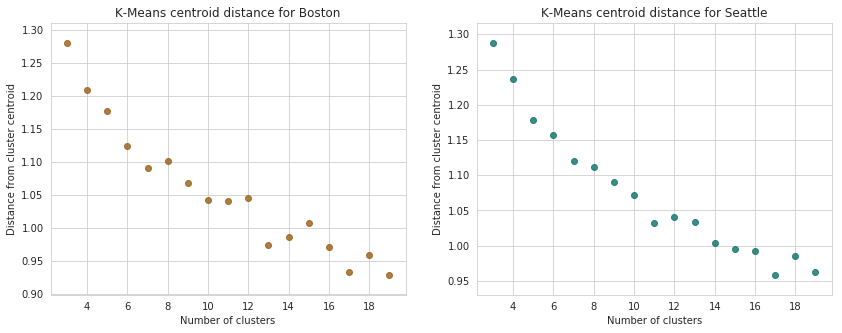

In [1387]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.regplot(x='step', y='dist', ax=ax[0], data=k_choice_b, color=boston1, fit_reg=False);
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Distance from cluster centroid')
ax[0].set_title('K-Means centroid distance for Boston')
sns.regplot(x='step', y='dist', ax=ax[1], data=k_choice_s, color=seattle1, fit_reg=False);
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Distance from cluster centroid')
ax[1].set_title('K-Means centroid distance for Seattle');

Apparently both curves show a small inflexion around 12 clusters. This is the number of clusters that I choose.

In [1388]:
n_clusters = 12
k_model_b = KMeans(n_clusters = n_clusters, random_state=34).fit(X_pca_b)
k_model_s = KMeans(n_clusters = n_clusters, random_state=34).fit(X_pca_s)

In [1389]:
# generate dataframe with partial populations in each cluster
pop_df_b = pd.DataFrame(np.unique(k_model_b.labels_), columns=['cluster'])
pop_df_b['population'] = np.bincount(k_model_b.labels_) / k_model_b.labels_.shape[0]

pop_df_s = pd.DataFrame(np.unique(k_model_s.labels_), columns=['cluster'])
pop_df_s['population'] = np.bincount(k_model_s.labels_) / k_model_s.labels_.shape[0]

Text(0.5, 1.0, 'Percentual cluster population for Seattle')

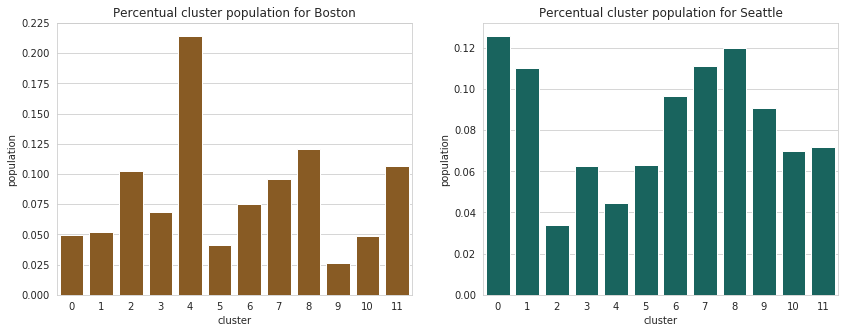

In [1390]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x='cluster', y='population', data=pop_df_b, color=boston1, ax=axes[0])
axes[0].set_title('Percentual cluster population for Boston')
sns.barplot(x='cluster', y='population', data=pop_df_s, color=seattle1, ax=axes[1])
axes[1].set_title('Percentual cluster population for Seattle')

Now, for the great moment, we will check which clusters have the highest population of properties with the maximum score (4) in terms of how many times they were rented.

In [1391]:
cluster_4_b = pd.DataFrame()
cluster_4_b['data_index'] = bdf_pca.index.values
cluster_4_b['score'] = boston_target
cluster_4_b['cluster'] = k_model_b.labels_

cluster_4_s = pd.DataFrame()
cluster_4_s['data_index'] = sdf_pca.index.values
cluster_4_s['score'] = seattle_target
cluster_4_s['cluster'] = k_model_s.labels_

For Boston clusters 5, 10 and 1 were ther three most important.

In [1392]:
cluster_4_b[cluster_4_b['score']==4]['cluster'].value_counts()

4     201
11    166
8     140
7     114
2      98
6      73
3      68
10     56
9      42
0      40
1      36
5      26
Name: cluster, dtype: int64

For Boston, the top four attributes give us the following information:

- attribute 4: This attribute is related to House properties at Jamaica Plain whose host are superhosts. The positive weights of the attribute grow with the number of bedrooms and the number of people the property can accommodate. The negative weights are related to the private rooms neighbourhood Fenway. They show that the attribute goes down with an increase in the number of listings per host, the host acceptance rate and the host response rate (so the less number of listings per host, the smaller the acceptance rate and the smaller the response rate).

- attribute 11: This attribute is related to properties in Dorchester, Beacon Hill, Downtown and North End. It shows that number of rents for properties in these regions grow with the number of bedrooms. It also shows that for Houses in Fenway, South End and Back Bay, the score goes down as the property is less occupied during the year (so these properties would have multiple rents as compared to the properties that are occupied for long times with only a few rents).

- attribute 8: This attribute is related to neighborhood Fenway and Jamaica Plain. It shows that properties with score 4 in these regions have moderate or strict cancellation policy. It also shows that high score is related to high number of listings per host. On the other hand, for Dorchester and Back Bay, this attribute shows that the lowest the host response rate, the lowest the host acceptance rate and the lowest the number of amenities 

- attribute 7: For South End and Dorchester, properties with modereate or strict cancellation policy also must require guest phone verification. On the other hand, for Fenway and Jamaica Plain, properties with less occupation and with newer hosts will have lower acceptance rates.

In [1413]:
var_comp_b.loc[0:4,['attribute_4','attribute_11','attribute_8','attribute_7']]

,attribute_4,attribute_11,attribute_8,attribute_7
0,property_type_House,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_South End
1,host_is_superhost,neighbourhood_cleansed_Beacon Hill,cancellation_policy_moderate,cancellation_policy_moderate
2,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Downtown,cancellation_policy_strict,require_guest_phone_verification
3,bedrooms,bedrooms,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Dorchester
4,accommodates,neighbourhood_cleansed_North End,host_listings_count,cancellation_policy_strict


In [1414]:
var_comp_b[-5:][['attribute_4','attribute_11','attribute_8','attribute_7']]

,attribute_4,attribute_11,attribute_8,attribute_7
67,host_listings_count,occupied,host_response_rate,occupied
68,host_acceptance_rate,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Dorchester,host_acceptance_rate
69,host_response_rate,property_type_House,amenities,host_since
70,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_South End,host_acceptance_rate,neighbourhood_cleansed_Fenway
71,room_type_Private room,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Jamaica Plain


In [1326]:
cluster_4_s[cluster_4_s['score']==4]['cluster'].value_counts()

2     138
5     105
1      97
3      95
9      93
11     88
0      84
6      66
7      63
4      54
8      40
10     31
Name: cluster, dtype: int64

In [1410]:
var_comp_s.loc[0:4,['attribute_2','attribute_5','attribute_1','attribute_3','attribute_9']]

,attribute_2,attribute_5,attribute_1,attribute_3,attribute_9
0,cancellation_policy_strict,require_guest_phone_verification,property_type_House,property_type_House,require_guest_phone_verification
1,Explained_Variance,require_guest_profile_picture,room_type_Private room,cancellation_policy_moderate,require_guest_profile_picture
2,room_type_Private room,cancellation_policy_moderate,cancellation_policy_strict,occupied,property_type_House
3,property_type_House,host_acceptance_rate,host_acceptance_rate,accommodates,instant_bookable
4,amenities,neighbourhood_cleansed_Belltown,host_response_rate,bedrooms,room_type_Shared room


In [1412]:
var_comp_s[-5:][['attribute_2','attribute_5','attribute_1','attribute_3','attribute_9']]

,attribute_2,attribute_5,attribute_1,attribute_3,attribute_9
131,instant_bookable,room_type_Private room,neighbourhood_cleansed_Belltown,property_type_Townhouse,bed_type_Real Bed
132,host_is_superhost,host_since,host_since,host_response_rate,occupied
133,cancellation_policy_moderate,occupied,occupied,neighbourhood_cleansed_Broadway,room_type_Private room
134,host_response_rate,instant_bookable,neighbourhood_cleansed_Broadway,host_acceptance_rate,cancellation_policy_moderate
135,host_acceptance_rate,host_is_superhost,cancellation_policy_moderate,room_type_Private room,cancellation_policy_strict


## 4. What are the most popular neighbourhoods? Can we understand why they are popular?

To solve this question we can use the neighborhood overview from the listings dataframe. The intereting thing about overviews is that they tend to be more well-behaved than the wild west of the reviews. The host will take more time to tailor the language which turns the text easier to be processed. Moreover, from what I aprehended, all overviews are in English.

The idea here is to aggregate reviews per neighborhood, turn them into a bag of words and process them usign Latent Dirichlet Allocation, a Bayesian statistics-based tool for analysis of trends in texts.

The first we notice in the listings dataframe is that almost 40% of the overviews are missing (come on, how can someone post a property and not write an overview?). 

In [1427]:
# 40% of neighborhood overviews missing
boston_listings['neighborhood_overview'].isnull().mean()

0.3947001394700139

We select only the list that are not null and create a new dataframe

In [1450]:
bl_no = boston_listings.loc[boston_listings['neighborhood_overview'].notnull(), 
                            ['neighbourhood_cleansed','neighborhood_overview']].copy()
bl_no.head()

,neighbourhood_cleansed,neighborhood_overview
0,Roslindale,"Roslindale is quiet, convenient and friendly. For Southern food try Redd's in Rozzie. Italian Delfino's or Sophia's Grotto are great. Birch St Bistro has nice atmostphere--a little pricier. If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods; for a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch St."
1,Roslindale,"The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away."
2,Roslindale,"The LOCATION: Roslindale is a safe and diverse Boston neighborhood located between Jamaica Plain and West Roxbury. This apartment is on Ardale Street, a quiet side street off Centre Street. This is about one-half mile from Faulkner Hospital, walking distance to the renowned Arnold Arboretum park (look for it on (SENSITIVE CONTENTS HIDDEN)), and about 20-minute drive to the Longwood Medical Center area. I have easy, restriction-free, on-street parking here, and a back yard. Just one block fr..."
3,Roslindale,"Roslindale is a lovely little neighborhood located right in the city of Boston. Though a part of the actual city, once you enter it, you feel as though you have escaped to a suburb with friendly neighbors. The area is conveniently located with access to the city’s bus and subway system. The Orange Line and Commuter Rail services connect the area to the heart of Boston and the neighboring towns. It is situated close to shops, restaurants, grocery stores, parks and neighboring towns. The ..."
4,Roslindale,"I love the proximity to downtown, the neighborhood pride, safety, nice shops and restaurants within a 8-minute walk. Roslindale is welcoming to all types of people. The City website describes it: ""Once considered a ""garden suburb"" of Boston, today's residents of Roslindale are still attracted to the neighborhood's natural beauty. Locals walk and bike in the Arnold Arboretum, a 265-acre oasis that is part of Frederick Law Olmsted's Emerald Necklace.....Roslindale Village is the city's orig..."


In [1430]:
bl_no.shape

(2170, 2)

Then we group the entries by neighborhood.

In [1466]:
bl_no_grouped = bl_no.groupby('neighbourhood_cleansed').agg({'neighborhood_overview':'sum'}).reset_index()
bl_no_grouped.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)
bl_no_grouped.head()

,neighbourhood,neighborhood_overview
0,Allston,"- The building is located on the border of Allston and Boston just west of Boston University. The building has a private parking lot (with parking tag of course - enquire with me if you drive) The building is surrounded by hedges and fences which gives it an intimate feel. - Super convenient and walkable - Shaws supermarket is a huge modern market with fresh produce, foreign or international foods, and every basic necessity you'll need. The market is just a few buildings away from our house..."
1,Back Bay,"Back BayGreat location near the Boston Common, Newbury Street, Esplanade, Charles River, Mass General Hospital and public transportation.Back Bay is an officially recognized neighborhood of Boston, Massachusetts famous for its rows of Victorian brownstone homes — considered one of the best-preserved examples of 19th-century urban design in the United States — as well as numerous architecturally significant individual buildings and important cultural institutions such as the Boston Public Lib..."
2,Bay Village,"- 1 block away from Loews Regency Hotel - 5 min walk to the Arlington Station - 5 min walk to Tufts Medical and Dental Center - Corner of Melrose and Arlington - Close to Theater District - Close to Quincy MarketOur townhome is located in the Bay Village neighborhood of Boston. It is nestled between Back Bay, the South End, and the Theatre District which make it the perfect spot for any traveler. Bay Village, known for its fabulous location and local charm, is steps from public transportatio..."
3,Beacon Hill,"Beacon Hill is a historic neighborhood of Boston famous for its gaslit lamps, brick sidewalks, and opulent mansions dating back to 1800. Our apartment is located on Mount Vernon Street, one of the first streets laid in the Beacon Hill area with many of the original homes preserved by the Beacon Hill Preservation Society. For history buffs: steps to the Black Heritage Trail, which follows the history of the Abolitionist movement and the Underground Railroad, the Freedom Trail, Louisberg Squa..."
4,Brighton,"Just steps away from the Charles River and easy driving access to Boston makes this neighborhood very convenient. The historic architecture is unique to the area. Sidewalk lined streets are fun to explore. Panoramic views of the City of Boston can be seen from neighboring streetsVery safe and convenient neighborhood close to Harvard Square. Walk to the grocery store, Brugger's bagels, sushi restaurant, wine store, breakfast places, restaurants, bus service to Harvard Square, etc.Cleveland ..."


In [1475]:
bl_no_grouped.shape

(25, 2)

We add boston to the list of stop words - the words that will not be considered as part of the vocabulary.

In [1493]:
my_stop_words=['boston','mi','miles']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [1504]:
list_msg=[]
for i in range(bl_no_grouped.shape[0]):
    count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
    X_train = count_vect.fit_transform([bl_no_grouped.loc[i,'neighborhood_overview']])
    lda = LatentDirichletAllocation(n_components=1,random_state=34)
    lda.fit(X_train) 
    feature_names = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        message = " ".join([feature_names[i] for i in topic.argsort()[:-8 :-1]])
    list_msg.extend([message])

In [1505]:
bl_no_grouped['message']=list_msg

Let's also add to this dataframe the mean classification score for number of rents

In [1506]:
bdf_lda = boston_df.copy()
bdf_lda['score'] = boston_target
bdf_lda['neighbourhood'] = boston_neigh
bdf_lda_grouped = bdf_lda.groupby('neighbourhood').agg({'score':'mean'})

In [1507]:
bl_no_lda = bl_no_grouped.merge(bdf_lda_grouped, on='neighbourhood')

In [1508]:
bl_no_lda[['neighbourhood','message','score']].sort_values(by='score', ascending=False)

,neighbourhood,message,score
16,Mission Hill,fine arts longwood medical museum fine minute walk mission hill medical area northeastern university,2.919355
0,Allston,harvard square min walk charles river students young walk away young professionals restaurants bars,2.819231
21,South Boston Waterfront,walking distance seaport district section city district hottest fort point harpoon brewery lots businesses,2.734940
22,South End,south end copley square walking distance newbury street end bay minute walk neighborhoods south,2.708589
3,Beacon Hill,beacon hill charles street charles river state house hill historic antique shops brick sidewalks,2.675258
17,North End,north end paul revere italian restaurants little italy faneuil hall public transportation old north,2.629371
10,Fenway,fenway park longwood medical heart dynamic parks theaters theaters nightlife museum fine museums parks,2.620690
4,Brighton,harvard square walking distance close harvard grocery store green line wine store store breakfast,2.610811
12,Jamaica Plain,jamaica plain jamaica pond arnold arboretum minute walk walking distance green space franklin park,2.586006
8,Downtown,faneuil hall downtown crossing north end public garden opera house td garden beacon hill,2.534884


The following are the most popular neighborhoods of Boston in terms of renting:

1. Mission Hill: It's at walking distance from the fine arts museum, it has the Longwood medical center and it is close to Harvard university
2. Allston - close to Harvard, within minutes walk from Charles river. Many young professionals leave there and it has several restaurants and bars
3. South Boston Waterfront - it is at walking distance from the seaport district. It is one of the hottest districts in the city and it is the location of the Harpoon brewery. There are lots of businesses.
4. South End - Copley square is at walking distance. It is crossed by Newbury street which has many restaurants and retails. 
5. Beacon Hill - Close to Charles street and Charles river. It is an historic neighborhood with brick sidewalls and antique shops.

That was interesting. It looks like we managed to get some meaningful information out of this mess.

In [ ]:
bl_no_lda.head()

Let's take this one step further and check what the reviews say about these neighbourhoods.